In [1]:
# setup
import gc
from typing import Tuple
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, top_k_accuracy_score, confusion_matrix
import torchaudio
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
import seaborn as sns

# TODO: change the file path
TEST_FILE_DIR = "./nsynth-test/audio"
TEST_LABEL_PATH = "./nsynth-test/examples.json"
RANDOM_SEED = 0
LABEL_NAMES = {0: "bass", 1: "brass", 2: "flute", 3: "guitar", 4: "keyboard", 5: "mallet", 6: "organ", 7: "reed", 8: "string", 9: "synth_lead", 10: "vocal"}


In [2]:
# load test file
test_df = pd.read_json(TEST_LABEL_PATH, orient='index')
print(test_df.columns)
print(test_df.shape)


Index(['qualities', 'pitch', 'note', 'instrument_source_str', 'velocity',
       'instrument_str', 'instrument', 'sample_rate', 'qualities_str',
       'instrument_source', 'note_str', 'instrument_family',
       'instrument_family_str'],
      dtype='object')
(4096, 13)


### Load data

In [3]:
# load test files
raw_wavs = []
mel_spectrograms = []
transform = MelSpectrogram(n_fft=2048, hop_length=512, sample_rate=16000)
to_db = AmplitudeToDB()
for filename in tqdm(test_df.index):
    filepath = f"{TEST_FILE_DIR}/{filename}.wav"
    wav, sr = torchaudio.load(filepath, normalize=True)
    raw_wavs.append(wav)
    mel_spec = to_db(transform(wav)).numpy()
    mel_spectrograms.append(mel_spec)

wavs_ml = np.concatenate(mel_spectrograms, axis=0)
del mel_spectrograms
gc.collect()
print("ML:", wavs_ml.shape)

wavs_dl = np.concatenate(raw_wavs, axis=0)
del raw_wavs
gc.collect()
print("DL:", wavs_dl.shape)


100%|██████████| 4096/4096 [00:03<00:00, 1106.63it/s]


ML: (4096, 128, 126)
DL: (4096, 64000)


### Feature Engineering (for ML)

In [4]:
def get_features(wavs: np.array, df: pd.DataFrame, pooling: str, metadata: bool = True) -> Tuple[np.array, np.array]:
    if pooling == 'mean':
        # mean pooling across time and normalized
        wavs = wavs.mean(axis=2)
    elif pooling == 'max':
        # max pooling across time and normalized
        wavs = wavs.max(axis=2)
    else:
        raise NotImplementedError('Only mean and max pooling are implemented.')

    wavs = normalize(wavs, norm='l2')

    if metadata:
        # hand-craft features: ["note",	"pitch", "velocity", "qualities"]
        x_qual = np.array(df["qualities"].apply(lambda x: np.array(x)).tolist())
        x_npv = df[["note",	"pitch", "velocity"]].values
        x_feat = np.hstack((x_qual, x_npv))
        X_train = np.hstack((wavs, x_feat))
    else:
        X_train = wavs
    y_train = df["instrument_family"].values
    print(f"X shape: {X_train.shape}, y shape: {y_train.shape}")

    return X_train, y_train

X_ml, y_ml = get_features(wavs_ml, test_df, 'mean')

X shape: (4096, 141), y shape: (4096,)


### Test ML model (RandomForestClassifier)

In [5]:
def test_ml(X_test: np.array, y_test: np.array, model: RandomForestClassifier, verbose: bool = True) -> float:
    # model testing
    y_pred = model.predict(X_test)
    y_pred_p = model.predict_proba(X_test)

    # Accuracy
    top1_acc = accuracy_score(y_test, y_pred)
    top3_acc = top_k_accuracy_score(y_test, y_pred_p, k=3, labels=list(LABEL_NAMES.keys()))
    print(f"Top 1 Accuracy: {top1_acc:.4f}")
    print(f"Top 3 Accuracy: {top3_acc:.4f}")

    # Confusion Matrix
    if verbose:
        cmx = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 4))
        sns.heatmap(cmx, annot=True, fmt='d', cmap='Blues', xticklabels=LABEL_NAMES.values(), yticklabels=LABEL_NAMES.values())
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

    return top1_acc
    


Top 1 Accuracy: 0.6875
Top 3 Accuracy: 0.8994


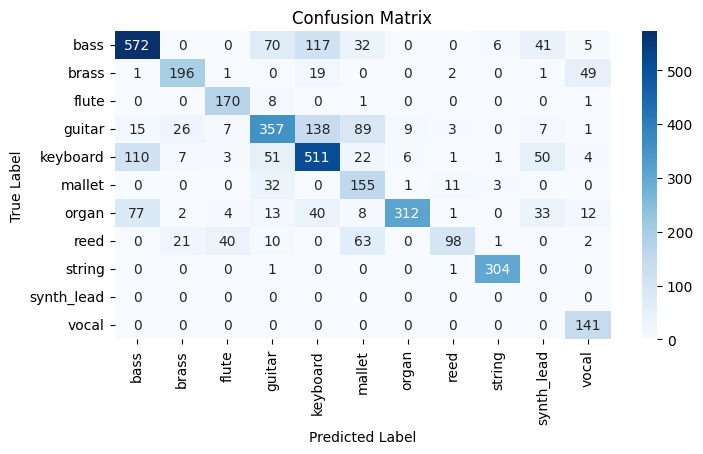

0.6875

In [6]:
# model: mean pooling + metadata
model_path = "ML_RandomForestCLF_best.pickle"
model1 = pickle.load(open(model_path, "rb"))
test_ml(X_ml, y_ml, model1)

### Test DL Model (ShortChunkCNN_Res)

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from model import ShortChunkCNN_Res

# DEVICE: GPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-params
EPOCHS = 10
PATIENCE = 30
BATCH_SIZE = 32  # 64
LR = 1e-5  # 1e-5


class MyDataset(Dataset):
    def __init__(self, wavs: np.array, log: pd.DataFrame):
        self.wavs = torch.tensor(wavs, dtype=torch.float32)
        self.target = torch.tensor(log["instrument_family"].values, dtype=torch.int64)
        x_qual = np.array(log["qualities"].apply(lambda x: np.array(x)).tolist())
        x_npv = log[["note",	"pitch", "velocity"]].values
        self.metadata = torch.tensor(np.hstack((x_qual, x_npv)), dtype=torch.float32)

    def __len__(self):
        return self.wavs.shape[0]
    
    def __getitem__(self, idx):
        return self.wavs[idx], self.target[idx], self.metadata[idx]


In [8]:
def test_dl(
        test_wavs: np.array, 
        test_log: pd.DataFrame, 
        model: ShortChunkCNN_Res,
        with_meta: bool = False,
        verbose: bool = True
    ):

    # Test Dataset and DataLoader
    test = MyDataset(test_wavs, test_log)
    test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()

    # test start
    model.to(DEVICE)
    model.eval()
    test_total_loss = 0
    test_true = torch.tensor([])
    test_pred = torch.tensor([])
    test_pred_p = torch.tensor([])
    with torch.no_grad():
        for test_wavs, test_target, test_metadata in tqdm(test_dataloader, disable=(not verbose)):
            test_wavs = test_wavs.to(DEVICE)
            test_target = test_target.to(DEVICE)
            test_metadata = test_metadata.to(DEVICE)

            if with_meta:
                output = model(test_wavs, test_metadata)
            else:
                output = model(test_wavs)

            loss = loss_fn(output, test_target)
            test_total_loss += loss.item()

            # Calculate Score
            test_target = test_target.cpu()
            output_label = torch.argmax(output, dim=-1).cpu()
            output = output.cpu()
            test_true = torch.cat([test_true, test_target])
            test_pred = torch.cat([test_pred, output_label])
            test_pred_p = torch.cat([test_pred_p, output])

            # Delete Var
            del test_wavs, test_target, test_metadata, output, output_label
            gc.collect()

    test_top1_acc = accuracy_score(test_true, test_pred)
    test_top3_acc = top_k_accuracy_score(test_true, test_pred_p, k=3, labels=list(LABEL_NAMES.keys()))

    print(f"Top 1 Accuracy: {test_top1_acc:.4f}")
    print(f"Top 3 Accuracy: {test_top3_acc:.4f}")

    if verbose:
        cmx = confusion_matrix(test_true, test_pred)
        plt.figure(figsize=(8, 4))
        sns.heatmap(cmx, annot=True, fmt='d', cmap='Blues', xticklabels=LABEL_NAMES.values(), yticklabels=LABEL_NAMES.values())
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

    return test_true, test_pred


100%|██████████| 128/128 [00:11<00:00, 11.11it/s]


Top 1 Accuracy: 0.7908
Top 3 Accuracy: 0.9070


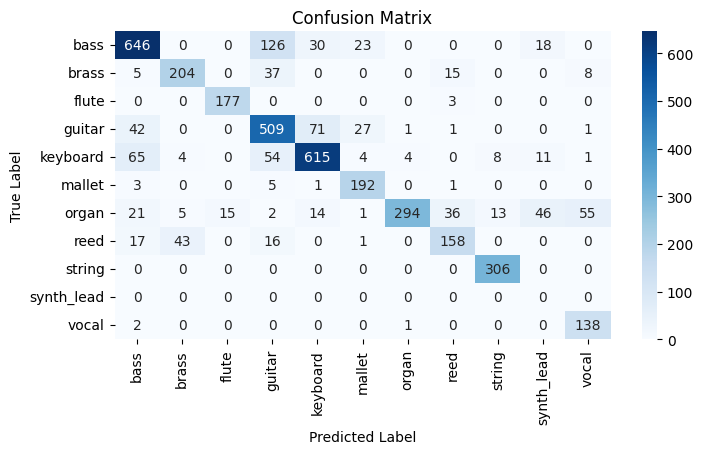

(tensor([0., 4., 3.,  ..., 8., 8., 0.]),
 tensor([0., 4., 3.,  ..., 8., 8., 0.]))

In [9]:
model_path = "DL_ShortChunkCNN_Res_2.pt"
model2 = ShortChunkCNN_Res(with_meta=True)
model2.load_state_dict(torch.load(model_path))
test_dl(wavs_dl, test_df, model2, with_meta=True)